<H1><center>Battle of the Neighborhoods  <br>-<br>What to Eat in a Financial Metropolis?</center></H1>

### <br><center>by Lutz Wimmer</center>

## Table of Contents:
* [Introduction](#c1)
* [The Data](#c2)
    * [Geolocation Data](#c2.1)
    * [Data Refinement](#c2.2)
* [Methodology](#c3)
* [Results](#c4)
* [Discussion](#c5)
    * [Low Risk Approach](#c5.1)
    * [High Risk Approach](#c5.2)
* [Conclusion](#c6)

## Introduction <a class="anchor" id="c1"></a>

Global financial centers are some of the most wealthy regions. They are spacially very concentrated and a hot spot for luxury products. In the aftermath of the coronavirus pandemic, thousands of restaurants shut down for good, even in the busy financial centers. But ones downfall is the others chance and people always need places to go and eat. New restaurants are needed! __The idea is to open a restaurant in Frankfurt am Main__ (short: FFM), Germany. As a restaurant, especially nowadays, you want to minimize risk. So this is part of a whole __market study__ an investor could rely on for his decisions. So what kind of restaurant? What does the international financial elite love to eat? Is there a prevalent type of restaurant between those cities? Let's find out!

## The Data <a class="anchor" id="c2"></a>

### Geolocation Data <a class="anchor" id="c2.1"></a>

Different cultures, different food, right? But do mondane people favor their native kitchen? Or do they all agree on one trendy type of food all over the world? To get a better overview, six cities with big financial centers will be analyzed: __New York, Toronto, Tokyo, London, Paris and Frankfurt__. The data used will be provided by <a href = "url">foursquare.com</a>, automatically downloaded via their API. The focus will lie on restaurants only, excluding cafes, bars, bistros and so on.

In [1]:
import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

<br>Adding "&query=food" to the Foursquare API url will get us only food-related venues. This way the search radius can be expanded without hitting the limit of 100 venues per city. The request and subsequent data frame building is looped over all 5 cities. A radius of 10 km for example would be too high and include restaurants far outside FFM and thus too far away to travel to for a business lunch. The radius of 7 km seems to be a good fit between the maximum number of venues and travel distance.

In [2]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# list of cities and their financial centers as coordinates
cities = ["New York", "Toronto", "Tokyo", "London", "Paris", "Frankfurt"]
latitudes = [40.7077426113486, 43.64803026178278, 35.679822325779995, 51.515259192193064, 48.875695105492134, 50.11081120228777]
longitudes = [-74.01157215146745, -79.3816696346114, 139.77014548424125, -0.08039578093893954, 2.3267329983906992, 8.67324827528688]
 
# Foursquare API credentials
CLIENT_ID = 'T0ETMOBTMRGKDWDG5VBSUFRUVWYJDTLHMLZHN2APZ545NNGR' # your Foursquare ID
CLIENT_SECRET = 'T03SSSFDVCM1JFVTX4YJLGS2IJPYD2AMRNWAR4DAXF2RFMZA' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 7000 # define radius

# a list to store all data frames in
all_df = list()

# loop over all 6 cities
for i in range(len(cities)):
# create URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query=food'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitudes[i], 
        longitudes[i], 
        radius, 
        LIMIT)

    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    nearby_venues['city'] = cities[i]
# add city name to column
    all_df.append(nearby_venues)
    
all_df[0].head()

<ipython-input-2-112cf702a079>:42: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng,city
0,Manhatta,New American Restaurant,40.707654,-74.009138,New York
1,Crown Shy,Restaurant,40.706187,-74.007490,New York
2,sweetgreen,Salad Place,40.705626,-74.008282,New York
3,Luke's Lobster,Seafood Restaurant,40.704488,-74.010915,New York
4,Pisillo Italian Panini,Sandwich Place,40.710530,-74.007526,New York


It would also been possible to store all the cities in one data frame, distinguishable by the "city" column. But I prefer to have them separated within a superstructure i can loop over. I guess it is just a matter of taste.

### <br>Data Refinement <a class="anchor" id="c2.2"></a>

#### Cleaning Restaurant Categories

Although bistros and cafes also serve food, for simplicity, we use restaurant-type categories only.

In [3]:
# list restaurants data frames
restaurants = list()
for i in range(6):
    restaurants.append(all_df[i][all_df[i]['categories'].str.match(".*Restaurant*.")])
restaurants[1].head()

,name,categories,lat,lng,city
0,Canoe,Restaurant,43.647452,-79.381320,Toronto
1,Richmond Station,American Restaurant,43.651569,-79.379266,Toronto
2,Pai,Thai Restaurant,43.647923,-79.388579,Toronto
3,The Keg Steakhouse + Bar - York Street,Restaurant,43.649987,-79.384103,Toronto
4,Byblos Toronto,Mediterranean Restaurant,43.647615,-79.388381,Toronto


Some restaurants don't have a specification for their kitchen, simply called "Restaurant". These will be assigned a "miscellaneous" type.<br>

In [4]:
for i in range(6):
    print("Number of restaurants in",cities[i],":  ",len(restaurants[i]))
    print("Misc. Restaurants:", sum(restaurants[i]['categories'].str.match("Restaurant")) )

Number of restaurants in New York :   60
Misc. Restaurants: 1
Number of restaurants in Toronto :   52
Misc. Restaurants: 7
Number of restaurants in Tokyo :   75
Misc. Restaurants: 1
Number of restaurants in London :   49
Misc. Restaurants: 7
Number of restaurants in Paris :   61
Misc. Restaurants: 4
Number of restaurants in Frankfurt :   48
Misc. Restaurants: 3


In [5]:
# renaming "Restaurants" to "Miscellaneous Restaurant"
for i in range(6):
    restaurants[i].loc[:]['categories'] = restaurants[i].loc[:]['categories'].replace('Restaurant','Miscellaneous Restaurant')
restaurants[1].head()

,name,categories,lat,lng,city
0,Canoe,Miscellaneous Restaurant,43.647452,-79.381320,Toronto
1,Richmond Station,American Restaurant,43.651569,-79.379266,Toronto
2,Pai,Thai Restaurant,43.647923,-79.388579,Toronto
3,The Keg Steakhouse + Bar - York Street,Miscellaneous Restaurant,43.649987,-79.384103,Toronto
4,Byblos Toronto,Mediterranean Restaurant,43.647615,-79.388381,Toronto


<br>The word "Restaurant" isn't needed anymore and will interfer with future visualization. Therefore we simply drop it.

In [6]:
remove_words = [' Restaurant']
pat = r'\b(?:{})\b'.format('|'.join(remove_words))

for i in range(6):
    restaurants[i].loc[:]['categories'] = restaurants[i].loc[:]['categories'].str.replace(pat, '')
restaurants[1].head()

,name,categories,lat,lng,city
0,Canoe,Miscellaneous,43.647452,-79.381320,Toronto
1,Richmond Station,American,43.651569,-79.379266,Toronto
2,Pai,Thai,43.647923,-79.388579,Toronto
3,The Keg Steakhouse + Bar - York Street,Miscellaneous,43.649987,-79.384103,Toronto
4,Byblos Toronto,Mediterranean,43.647615,-79.388381,Toronto


Finally, a map of the restaurants to see if we really got all the data we wanted or maybe even too much.

In [7]:
f = folium.Figure(width=800, height=300)
map_all = folium.Map(location=[latitudes[5], longitudes[5]], zoom_start=2).add_to(f)

# add markers to map
for i in range(6):
    for lat, lng, name, category in zip(restaurants[i]['lat'], restaurants[i]['lng'], restaurants[i]['name'], restaurants[i]['categories']):
        label = '{}, {}'.format(name, category)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_all)  
map_all

#### <br> Consolidation of Redundant Categories

First, let's visualize the data as horizontal bar plot.

In [8]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

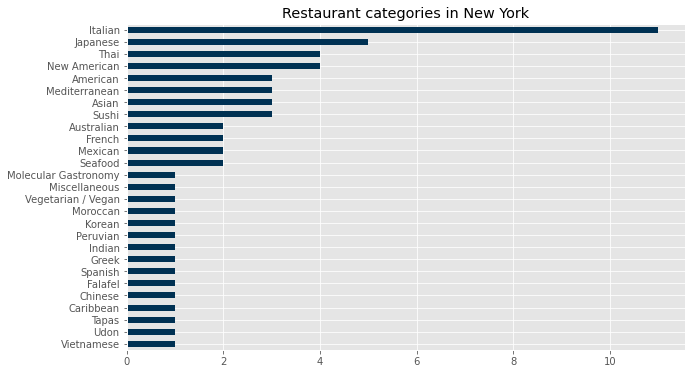

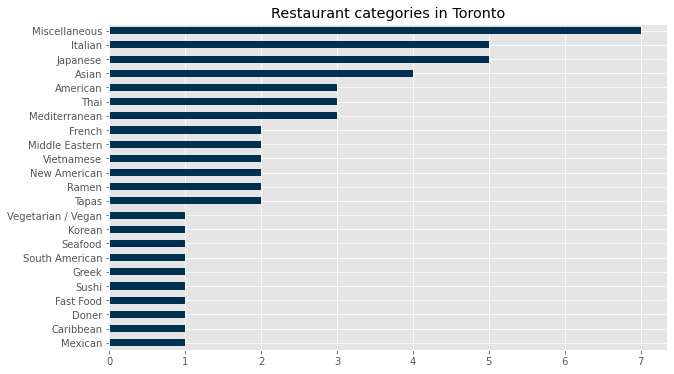

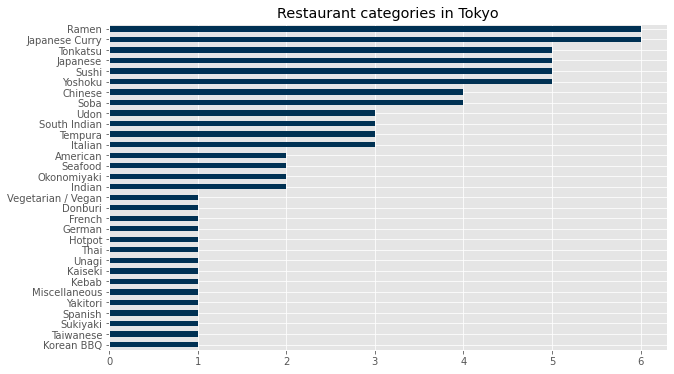

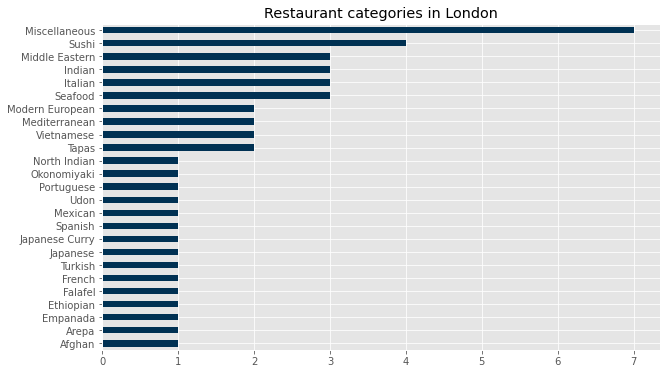

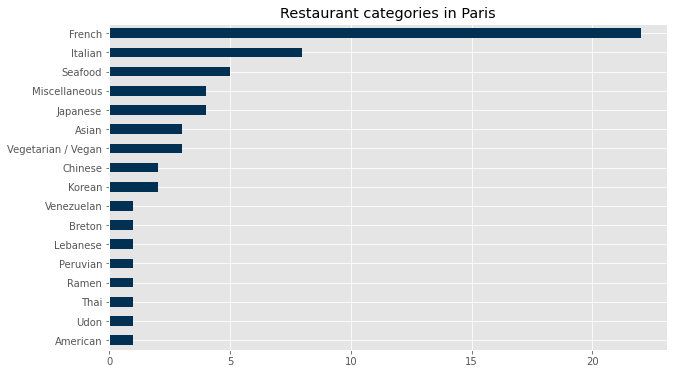

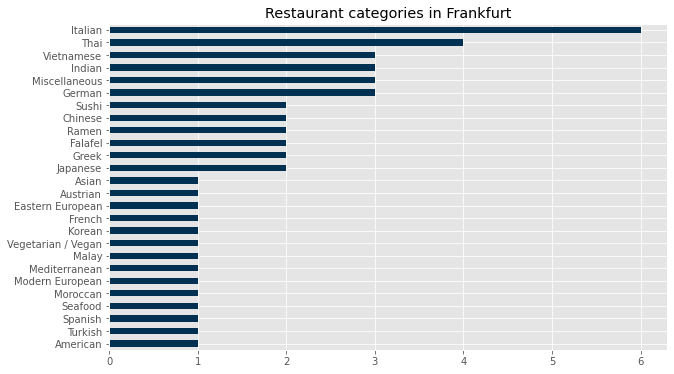

In [9]:
# Syntax axes([x_low, y_low, width, height])
# xu = [0,0.55,0,0.55,0,0.55]
# yu = [0.7,0.7,0.35,0.35,0,0]

for i in range(6):
    bar = restaurants[i].groupby('categories')['name'].nunique().sort_values(ascending=True)
    # plt.axes([xu[i],yu[i],0.4,0.3])
    bar.plot(kind = 'barh', figsize=(10, 6), color = '#003153')
    plt.title('Restaurant categories in {}'.format(cities[i]), color = 'black')
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

We can see, that in __Paris and Tokyo, the respective national kitchen__ is by far the most favourite one, whereas in __New York and Franfurt the Italian cuisine__ dominates. Another similarity is found between __London and Toronto with "miscellaneous" Restaurants being the top one__, followed by Italian cuisine. Now the "miscellaneous" category is a real problem here, since we don't know what kind of food they serve and we don't know if the restaurant type just wasn't specified by the Foursquare users despite belonging to a certain type. Another "problem" is Tokyo, or to be precise: the Japanese cuisine. Japanese restaurants are often more like small street food venues, serving just a specific Japanese dish. For comparability reasons, all the single Japanese dishes will be merged into the "Japanese" type, with exception of "Sushi". Sushi places are found in every city and quite popular, except in Paris, where it might fall into the category "Seafood". There are several more examples of duplicity, but we have to be careful not to simplify the data too much, since a specific subtype, like "Tapas", might be much more favoured than the regional type it belongs to. Let's start with Tokyo.

In [10]:
# Tokyo
tokyo = restaurants[2].groupby('categories')['name'].nunique().sort_values(ascending=True)
filt = ['Ramen', 'Tonkatsu', 'Japanese Curry', 'Yoshoku', 'Soba', 'Udon', 'Tempura', 'Okonomiyaki', 'Unagi', 'Donburi', 'Hotpot', 'Kaiseki', 'Yakitori', 'Sukiyaki']
tokyo['Japanese'] = tokyo['Japanese'] + sum(tokyo[filt])
tokyo.drop(filt, inplace = True)

# 'Indian' and 'South Indian' will be merged as well, 'Korean BBQ' will be renamed to 'Korean'
tokyo.rename(index={'Korean BBQ':'Korean'},inplace=True)
tokyo['Indian'] = tokyo['Indian'] + tokyo['South Indian']
tokyo.drop('South Indian', inplace = True)
# japan.plot(kind = 'barh', figsize=(20, 10), color = '#003153')

In [11]:
# New York
newyork = restaurants[0].groupby('categories')['name'].nunique().sort_values(ascending=True)

# adding 'American' and 'New American' together and 'Udon' to 'Japanese'
newyork['American'] = newyork['American'] + newyork['New American']
newyork['Japanese'] = newyork['Japanese'] + newyork['Udon']
newyork.drop(['New American', 'Udon'], inplace = True)
# newyork.sort_values(ascending=True).plot(kind = 'barh', figsize=(20, 10), color = '#003153')

In [12]:
# Toronto
toronto = restaurants[1].groupby('categories')['name'].nunique().sort_values(ascending=True)

# adding 'American' and 'New American' together and 'Ramen' to 'Japanese'
toronto['American'] = toronto['American'] + toronto['New American']
toronto['Japanese'] = toronto['Japanese'] + toronto['Ramen']
toronto.drop(['New American', 'Ramen'], inplace = True)
# toronto.sort_values(ascending=True).plot(kind = 'barh', figsize=(20, 10), color = '#003153')

In [13]:
# London
london = restaurants[3].groupby('categories')['name'].nunique().sort_values(ascending=True)

# adding 'Arepa' and 'Empanada' to 'Mexican'. 'Udon', 'Okonomiyaki', 'Japanese Curry' to 'Japanese'
london['Mexican'] = london['Mexican'] + london['Arepa'] + london['Empanada']
london['Japanese'] = london['Japanese'] + london['Udon'] + london['Okonomiyaki'] + london['Japanese Curry']
london.drop(['Arepa', 'Empanada','Udon','Okonomiyaki','Japanese Curry'], inplace = True)
# london.sort_values(ascending=True).plot(kind = 'barh', figsize=(20, 10), color = '#003153')

In [14]:
# Paris
paris = restaurants[4].groupby('categories')['name'].nunique().sort_values(ascending=True)

# adding 'Udon' and 'Ramen' to 'Japanese' and 'Breton' to 'French'
paris['French'] = paris['French'] + paris['Breton']
paris['Japanese'] = paris['Japanese'] + paris['Udon'] + paris['Ramen']
paris.drop(['Udon','Breton','Ramen'], inplace = True)
# paris.sort_values(ascending=True).plot(kind = 'barh', figsize=(20, 10), color = '#003153')

In [15]:
# Frankfurt
ffm = restaurants[5].groupby('categories')['name'].nunique().sort_values(ascending=True)

# adding 'Ramen' to 'Japanese'
ffm['Japanese'] = ffm['Japanese'] + ffm['Ramen']
ffm.drop(['Ramen'], inplace = True)
# ffm.sort_values(ascending=True).plot(kind = 'barh', figsize=(20, 10), color = '#003153')

With the categories now nice and clean, we can finally start to analyze the similarities between the cities.

## <br>Methodology <a class="anchor" id="c3"></a>

First we try to establish the similarity between the cities. To do so, the Pearson correlation coefficient _r_ is calculated. Since Frankfurt is our point of reference, we calculate the _r_ value between Frankfurt and the other 5 cities. This gives us the advantage to ignore restaurant categories, that are not present in Frankfurt, but the other city it is paired to.

In [16]:
# combine all data to pandas data frame
df1 = pd.DataFrame(index = ffm.index, columns = ['Frankfurt','Paris','London','New York','Toronto','Tokyo'])
df1.loc[set(df1.index) & set(ffm.index), 'Frankfurt'] = ffm[set(df1.index) & set(ffm.index)]
df1.loc[set(df1.index) & set(paris.index), 'Paris'] = paris[set(df1.index) & set(paris.index)]
df1.loc[set(df1.index) & set(london.index), 'London'] = london[set(df1.index) & set(london.index)]
df1.loc[set(df1.index) & set(newyork.index), 'New York'] = newyork[set(df1.index) & set(newyork.index)]
df1.loc[set(df1.index) & set(toronto.index), 'Toronto'] = toronto[set(df1.index) & set(toronto.index)]
df1.loc[set(df1.index) & set(tokyo.index), 'Tokyo'] = tokyo[set(df1.index) & set(tokyo.index)]
df1.fillna(0, inplace= True)
df1.tail(8)

,Frankfurt,Paris,London,New York,Toronto,Tokyo
categories,,,,,,
Chinese,2,2,0,1,0,4
Sushi,2,0,4,3,1,5
German,3,0,0,0,0,1
Miscellaneous,3,4,7,1,7,1
Indian,3,0,3,1,0,5
Vietnamese,3,0,2,1,2,0
Thai,4,1,0,4,3,1
Italian,6,8,3,11,5,3


Now we can run the Perason correlation provided by scipy. It is important to note, that the data for the correlation does not include _nan_ values and both variables (cites) have the same data length. The correlation results are shown in the __Results__ section. Another possibility is to include all categories over all cities, so we can calculate the correlation between all cities. For that, we only have to alter the data frame a bit.

In [17]:
# list with all categories
cat = ffm.index.tolist() + paris.index.tolist() + london.index.tolist() + newyork.index.tolist() + toronto.index.tolist() + tokyo.index.tolist()
# using only unique category values
cat = np.unique(cat).tolist()

df = pd.DataFrame(index = cat, columns = ['Frankfurt','Paris','London','New York','Toronto','Tokyo'])
df.loc[set(df.index) & set(ffm.index), 'Frankfurt'] = ffm[set(df.index) & set(ffm.index)]
df.loc[set(df.index) & set(paris.index), 'Paris'] = paris[set(df.index) & set(paris.index)]
df.loc[set(df.index) & set(london.index), 'London'] = london[set(df.index) & set(london.index)]
df.loc[set(df.index) & set(newyork.index), 'New York'] = newyork[set(df.index) & set(newyork.index)]
df.loc[set(df.index) & set(toronto.index), 'Toronto'] = toronto[set(df.index) & set(toronto.index)]
df.loc[set(df.index) & set(tokyo.index), 'Tokyo'] = tokyo[set(df.index) & set(tokyo.index)]
df.fillna(0, inplace= True)
df.head(8)

,Frankfurt,Paris,London,New York,Toronto,Tokyo
Afghan,0,0,1,0,0,0
American,1,1,0,7,5,2
Asian,1,3,0,3,4,0
Australian,0,0,0,2,0,0
Austrian,1,0,0,0,0,0
Caribbean,0,0,0,1,1,0
Chinese,2,2,0,1,0,4
Doner,0,0,0,0,1,0


The difference here is, that the "Frankfurt" column also has 0-values and it includes all categories.

## <br>Results <a class="anchor" id="c4"></a>

### Similarity between Cities <a class="anchor" id="c4.1"></a>

The Pearson correlation between the cities paired to Frankfurt point of reference are as followed:

In [18]:
from scipy.stats import pearsonr

for i in range(1,6):
    print(df1.columns[0],"-",df1.columns[i], "r:", round(pearsonr(df1.iloc[:,0],df1.iloc[:,i])[0],3), "| p-val.:", round(pearsonr(df1.iloc[:,0],df1.iloc[:,i])[1],3))

Frankfurt - Paris r: 0.115 | p-val.: 0.584
Frankfurt - London r: 0.433 | p-val.: 0.03
Frankfurt - New York r: 0.606 | p-val.: 0.001
Frankfurt - Toronto r: 0.498 | p-val.: 0.011
Frankfurt - Tokyo r: 0.386 | p-val.: 0.057


The highest correlation is found between Frankfurt and New York with __r = 0.6__ and a __p-value < 0.05__, followed by Toronto (r ~ 0.5) and London (r = 0.43). Tokyo shows also a high correlation (r ~ 0.4) but it is not significant (p-value > 0.05). Most interesting is the low correlation between Frankfurt and Paris (r = 0.1) with a whopping p-value of 0.6, meaning not only that they are very dissimilar but also that the similarity they share is likely to be random. Now if we look at the second approach, correlating all cities with each other, we can easily calculate a correlation-matrix out of the data frame.

In [19]:
# correlation matrix
df.corr()

,Frankfurt,Paris,London,New York,Toronto,Tokyo
Frankfurt,1.000000,0.273993,0.429313,0.650864,0.554981,0.413552
Paris,0.273993,1.000000,0.195868,0.367792,0.375848,0.217794
London,0.429313,0.195868,1.000000,0.296450,0.565341,0.354847
New York,0.650864,0.367792,0.296450,1.000000,0.705790,0.401946
Toronto,0.554981,0.375848,0.565341,0.705790,1.000000,0.503479
Tokyo,0.413552,0.217794,0.354847,0.401946,0.503479,1.000000


This can be visualized with a heat map using the _seaborn_ library

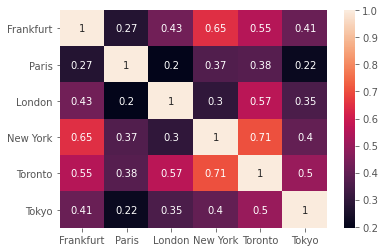

In [20]:
import seaborn as sn
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

This shows us that the highest correlation is found between New York and Toronto, not very surprising given their proximity. Correlation between Frankfurt and New York has slightly increased to __0.65__, due to the higher number of categories taken into account. The question now is, how to use this information about the similarity between Frankfurt and other cities to recommend a restaurant category. Another differentiation should be made between the "strategy" of the investor. This comes down to two different approaches: low risk and high risk.

## Discussion <a class="anchor" id="c5"></a>

### Low Risk Approach <a class="anchor" id="c5.1"></a>

"Low risk" in this context means that the recommendation for a restaurant category is based on what is already popular in Frankfurt and highly correlated cities. This investment poses the lowest risk of failing dependant on the restaurant category alone. This can also be subdivided into two different approaches: 
       <br><center>__a)__ we either recommend what is popular in both, Frankfurt and the other city. Or 
       <br>__b)__ we recommend what is popular in highly correlated cites but not in Frankfurt. </center>
<br>This way the investor can open a restaurant that doesn't has much competition in Frankfurt, but is popular in cities similar to Frankfurt. (b) seems to be the best way to recommend a restaurant category, since recommending to open Italian restaurant number 7 probably won't fly with the investor.

We simply subtract the restaurant categories percentage of Frankfurt from the other cities. By that we get values between -1 and 1 with 1 being a category much more prevalent in Frankfurt and -1 much more prevalent in the other city. "0" means that either both cities have the same percentage of this restaurant category or neither has one. We will compare Frankfurt to New York and Toronto alone with both having a _r > 0.5_.

In [21]:
a = (df['Frankfurt']/sum(df['Frankfurt']))-(df['New York']/sum(df['New York']))
a.sort_values(ascending = True)[0:15]

American               -0.097811
Italian                -0.061441
Australian             -0.033898
Mexican                -0.033898
Asian                  -0.030014
Mediterranean          -0.030014
Japanese               -0.018362
Caribbean              -0.016949
Molecular Gastronomy   -0.016949
Peruvian               -0.016949
Tapas                  -0.016949
Seafood                -0.013065
French                 -0.013065
Sushi                  -0.009181
Afghan                  0.000000
dtype: float64

So the __low risk (b)__ recommendation  from the comparison with New York would clearly be an __"American" restaurant__ with only 1 American restaurant in Frankfurt. __"Italian"__ restaurant would be definetely be the recommendation for the __low risk (a)__ approach, being the most popular category in both cities.

In [22]:
b = (df['Frankfurt']/sum(df['Frankfurt']))-(df['Toronto']/sum(df['Toronto']))
b.sort_values(ascending = True)[0:15]

American         -0.075321
Miscellaneous    -0.072115
Asian            -0.056090
Japanese         -0.051282
Middle Eastern   -0.038462
Tapas            -0.038462
Mediterranean    -0.036859
Doner            -0.019231
Mexican          -0.019231
Fast Food        -0.019231
Caribbean        -0.019231
South American   -0.019231
French           -0.017628
Peruvian          0.000000
Kebab             0.000000
dtype: float64

The __low risk (b)__ recommendation from Toronto is either an American or an "Miscellaneous" restaurant with 3 of latter being already in Frankfurt. But "Miscellaneous" could mean a lot and doesn't provide much information for the investor. The __low risk (a)__ recommendation would be an "Asian" or "Japanese" restaurant. Since there are already a lot of Asian, Thai, Japanese and so on restaurants in Frankfurt, these restaurants seem to be a real evergreen in Frankfurt.

### High Risk Approach <a class="anchor" id="c5.2"></a>

Under "high risk" we understand a recommendation of a category that isn't found in Frankfurt, but popular in Toronto or New York. Considering categories from cities with low similarity to Frankfurt and not existing there could be defined as "maximum risk" approach.

We simply subtract the category names of Frankfurt from New York/Toronto to get the categories only found in New York, then look at the amount of those categories in New York/Toronto.

In [23]:
c = df.loc[set(newyork.index) - set(ffm.index),'New York'].sort_values(ascending=False)
c

Mexican                 2
Australian              2
Tapas                   1
Molecular Gastronomy    1
Peruvian                1
Caribbean               1
Name: New York, dtype: int64

In [24]:
d = df.loc[set(toronto.index) - set(ffm.index),'Toronto'].sort_values(ascending=False)
d

Tapas             2
Middle Eastern    2
South American    1
Fast Food         1
Doner             1
Mexican           1
Caribbean         1
Name: Toronto, dtype: int64

In [25]:
e = c+d
e.sort_values(ascending=False)

Tapas                   3.0
Mexican                 3.0
Caribbean               2.0
Australian              NaN
Doner                   NaN
Fast Food               NaN
Middle Eastern          NaN
Molecular Gastronomy    NaN
Peruvian                NaN
South American          NaN
dtype: float64

The combined __high risk__ recommendation from New York and Toronto would be either a __Tapas__ or a __Mexican__ restaurant, with "Carribean" also being an alternative.

## Conclusion <a class="anchor" id="c6"></a>

The investor now has his possible restaurant categories narrowed down to just a few (__American, Italian, Miscellaneous, Asian/Japanese, Tapas or Mexican__). Ultimately, he will decide between one of those based on their profit potenial. To estimate the potential profit of a restaurant category is very complex and many aspects go into that (e.g. the cost of food of that cuisine). Therefore it is vital to have just a narrow selection that needs to be analyzed. This approach is very similiar to "collaborative filtering" used by video streaming services like Netflix. Analoguous to the Netflix user, we evaluated the "preferences" of a whole city, compared them to the preferences of others and recommended based on different approaches.

#### <br><br> <center>Big thanks to IBM for this awesome course! It has been assured me that I really want to become a professional Data Science. Also shoutout to Coursera for being just the perfect platform for gaining skills!</center>